MODELOS DE Feed Forward NN PARA DEMANDA DE GAS NATURAL EN SECTOR ELÉCTRICO EN MÉXICO

https://github.com/bnsreenu/python_for_microscopists/blob/master/164b-Intro_to_time_series_Forecasting_using_feed_forward_NN_and_TimeseriesGenerator.py

https://github.com/bnsreenu/python_for_microscopists/tree/master

https://www.youtube.com/watch?v=tKM5d8Ll1k0


Importamos la data de Demanda de gas en sector eléctrico como un CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
csv_demanda_electrico_original = pd.read_csv('Demanda_electrico_2022_full1.csv',index_col='Date',parse_dates=True)
csv_demanda_electrico_original

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2022-05-01,3350.03
2022-06-01,3498.70
2022-07-01,3350.97


Vamos a graficar los datos "originales" de demanda eléctrico desde 2005 hasta 2022

Text(0, 0.5, 'Demanda [MMpcd]')

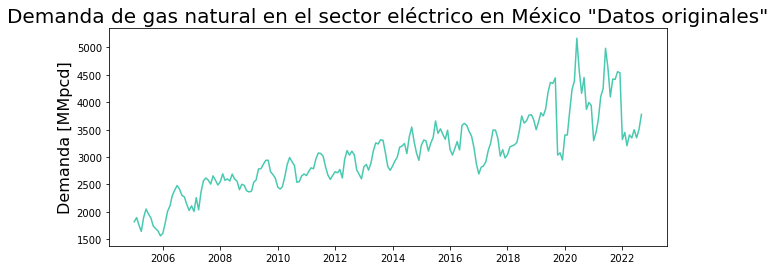

In [3]:
plt.figure(figsize=(10,4))
plt.plot(csv_demanda_electrico_original, color='#48C9B0')
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Vamos a descomponer la serie de tiempo de datos "originales" de demanda eléctrico desde 2005 hasta 2022 en sus compoentes de Tendencia, Estacionalidad y Residual 

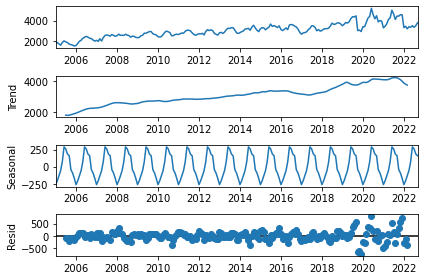

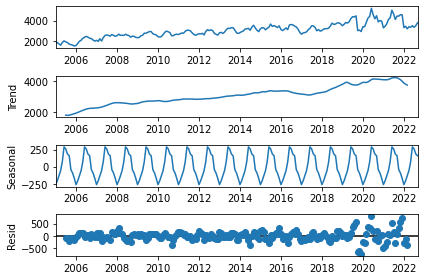

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

csv_demanda_electrico_original_seasonal_decomposition = seasonal_decompose(csv_demanda_electrico_original)
csv_demanda_electrico_original_seasonal_decomposition.plot()

Separamos la Demanda de gas natural en el sector eléctrico en data de train y test

In [5]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
csv_demanda_electrico_original_train_data = csv_demanda_electrico_original[:-num_test_points]
csv_demanda_electrico_original_test_data = csv_demanda_electrico_original[-num_test_points:]

csv_demanda_electrico_original_train_data

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2021-05-01,4243.93
2021-06-01,4985.53
2021-07-01,4631.85


In [12]:
csv_demanda_electrico_original_train_data.reset_index(drop=True, inplace=True)

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [13]:
from keras.preprocessing.sequence import TimeseriesGenerator

Se aplica el TimeseriesGnerator para producir sets de n_inputs + 1 output para el caso de

In [14]:
n_input = 24
demanda_electrico_NOscaled_train_generator = TimeseriesGenerator(csv_demanda_electrico_original_train_data, csv_demanda_electrico_original_train_data, length=n_input, batch_size=1)
demanda_electrico_NOscaled_train_generator

In [16]:
# Access the first batch of data
batch_x, batch_y = next(iter(demanda_electrico_NOscaled_train_generator))


KeyError: 24

De tal manera que se toman por ejemplos los primeros n_input elementos del array csv_demanda_electrico_scaled_train y se deja el siguiente elemento n_input + 1 como "output" 

In [15]:
demanda_electrico_NOscaled_train_generator[0]

KeyError: 24

ERROR EXPLANATION: The TimeseriesGenerator expects two arguments: data and targets. It seems you are passing the same DataFrame csv_demanda_electrico_original_train_data as both data and targets. This could be causing the error.

You should provide different data and target sequences to the generator. Assuming that csv_demanda_electrico_original_train_data contains your time series data, you should split it into input data (data) and target data (targets) like this:

In [20]:
n_input = 24

# Assuming you have a column in your DataFrame named 'demand_data' that contains your time series data
data = csv_demanda_electrico_original_train_data['Demanded_Gas'].values
targets = data  # You can adjust this if your target data is different

demanda_electrico_NOscaled_train_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)

# Access the first batch of data
batch_x, batch_y = next(iter(demanda_electrico_NOscaled_train_generator))


In [22]:
demanda_electrico_NOscaled_train_generator[1]

(array([[1895.33, 1765.86, 1642.7 , 1895.54, 2051.72, 1962.05, 1889.66,
         1739.1 , 1695.92, 1648.95, 1560.98, 1610.45, 1806.33, 2006.88,
         2108.31, 2298.9 , 2398.88, 2480.62, 2413.08, 2298.49, 2273.91,
         2134.41, 2025.98, 2108.85]]),
 array([2006.81]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [23]:
print("Total number of samples in the original training data = ", len(csv_demanda_electrico_original_train_data)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_NOscaled_train_generator))

Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  177


Se importan las librerias necesarias para definir la red Neuronal de tipo Feed Forward Sequential Neural Network

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Se define la red neuronal sequencial FFNN con capas densas y funcion de activación tipo RELU. 

La primer cada Dense constará de N, nodos y n_input inputs.
Por lo que el número de parámetros a estimar para esta primer capa sería 
Parámetros_n_capa_densa = n_input *  #Nodos + # Nodos
Donde  n_input *  #Nodos: Representa la matriz de pesos 
Y # Nodos: el vector de bias  


Note: By setting input_shape=(n_input, n_features) in the first Dense layer, you're correctly specifying that each input sample will have a shape of (24, 1), which matches the shape of the data generated by your TimeseriesGenerator.

In [25]:
n_input = 24
n_features = 1

# define model
model_sequential_and_FF = Sequential()
model_sequential_and_FF.add(Dense(64, activation='relu', input_shape=(n_input, n_features)))
model_sequential_and_FF.add(Dense(32, activation='relu'))
model_sequential_and_FF.add(Dense(1))
model_sequential_and_FF.compile(optimizer='Adam', loss='mse')

In [26]:
model_sequential_and_FF.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24, 64)            128       
                                                                 
 dense_1 (Dense)             (None, 24, 32)            2080      
                                                                 
 dense_2 (Dense)             (None, 24, 1)             33        
                                                                 
Total params: 2241 (8.75 KB)
Trainable params: 2241 (8.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Detalle del número de parámetros por cada en la Sequential FF NN 

- Primer capa

In [16]:
(64 * n_input) + 64

1600

- Segunda capa

In [17]:
(32 * 64) + 32

2080

- Tercer Capa

In [18]:
(32 * 1) + 1

33

Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_electrico_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [27]:
model_sequential_and_FF.fit(demanda_electrico_NOscaled_train_generator, epochs=25)

Epoch 1/25
177/177 [==============================] - 2s 2ms/step - loss: 2432783.0000
Epoch 2/25
177/177 [==============================] - 0s 2ms/step - loss: 182519.7500
Epoch 3/25
177/177 [==============================] - 0s 2ms/step - loss: 183480.5156
Epoch 4/25
177/177 [==============================] - 0s 2ms/step - loss: 181578.1406
Epoch 5/25
177/177 [==============================] - 0s 3ms/step - loss: 185360.7188
Epoch 6/25
177/177 [==============================] - 0s 2ms/step - loss: 189233.7812
Epoch 7/25
177/177 [==============================] - 0s 2ms/step - loss: 185625.4531
Epoch 8/25
177/177 [==============================] - 0s 2ms/step - loss: 185102.9531
Epoch 9/25
177/177 [==============================] - 0s 2ms/step - loss: 189186.5312
Epoch 10/25
177/177 [==============================] - 0s 2ms/step - loss: 188290.5312
Epoch 11/25
177/177 [==============================] - 0s 2ms/step - loss: 191061.3750
Epoch 12/25
177/177 [==============================

In your model, you have defined a feedforward neural network with the following layers:

1. Input layer with input_dim=24.
2. A hidden layer with 64 units and ReLU activation.
3. Another hidden layer with 32 units and ReLU activation.
4. An output layer with 1 unit (assuming you are predicting a single value).

The error specifically occurs during the matrix multiplication in the second dense layer (dense_2). Here's why:

The input shape for this layer is [batch_size, input_dim], where batch_size is determined by your data generator, and input_dim is 24.
The weight matrix for this layer has a shape of [input_dim, 32], which means it expects the input to have 24 features (columns), but your input has only 1 feature because you're processing sequential data.

The error specifically occurs during the matrix multiplication in the second dense layer (dense_2). Here's why:

The input shape for this layer is [batch_size, input_dim], where batch_size is determined by your data generator, and input_dim is 24.
The weight matrix for this layer has a shape of [input_dim, 32], which means it expects the input to have 24 features (columns), but your input has only 1 feature because you're processing sequential data.

Se grafica la perdida por epoch 

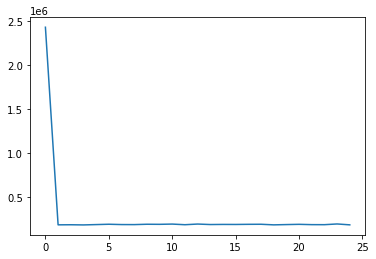

In [28]:
loss_per_epoch = model_sequential_and_FF.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [33]:

data = csv_demanda_electrico_original_train_data['Demanded_Gas'].values

demanda_electrico_NOscaled_train_batch = data[-n_input:]


demanda_electrico_NOscaled_train_batch

array([3037.44, 3076.62, 2947.09, 3402.47, 3402.47, 3819.3 , 4235.25,
       4387.91, 5168.27, 4581.99, 4163.77, 4451.61, 3869.77, 3996.14,
       3941.12, 3298.43, 3454.21, 3681.3 , 4104.82, 4243.93, 4985.53,
       4631.85, 4098.81, 4424.39])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [34]:
demanda_electrico_NOscaled_train_batch_reshaped = demanda_electrico_NOscaled_train_batch.reshape(1,n_input, n_features)
demanda_electrico_NOscaled_train_batch_reshaped

array([[[3037.44],
        [3076.62],
        [2947.09],
        [3402.47],
        [3402.47],
        [3819.3 ],
        [4235.25],
        [4387.91],
        [5168.27],
        [4581.99],
        [4163.77],
        [4451.61],
        [3869.77],
        [3996.14],
        [3941.12],
        [3298.43],
        [3454.21],
        [3681.3 ],
        [4104.82],
        [4243.93],
        [4985.53],
        [4631.85],
        [4098.81],
        [4424.39]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [35]:
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)

1/1 [==============================] - 1s 1s/step


array([[[3203.2737],
        [3244.5576],
        [3108.0732],
        [3587.901 ],
        [3587.901 ],
        [4027.1099],
        [4465.391 ],
        [4626.2466],
        [5448.5024],
        [4830.747 ],
        [4390.0737],
        [4693.366 ],
        [4080.289 ],
        [4213.444 ],
        [4155.4697],
        [3478.2754],
        [3642.419 ],
        [3881.7012],
        [4327.958 ],
        [4474.5376],
        [5255.951 ],
        [4883.2837],
        [4321.626 ],
        [4664.6855]]], dtype=float32)

Y se observa el valor predicho ESCALADO para la demanda de gas en el primer mes o dato de prueba como función de los n datos anteriores y dado el modelo model_sequential_and_FF

In [36]:
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][-1][0]

1/1 [==============================] - 0s 44ms/step


4664.6855

Y se compara el valor de forecast del modelo model_sequential_and_FF con los datos (ESCALADOS) de test de la demanda de gasd natural en sector eléctrico  

In [44]:
csv_demanda_electrico_original_test_data['Demanded_Gas'].values[0]

4417.51

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo 

In [45]:
n_input = 24
n_features = 1

In [46]:
test_predictions_model_sequential_and_FF = []

first_eval_batch = csv_demanda_electrico_original_train_data['Demanded_Gas'].values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(csv_demanda_electrico_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_sequential_and_FF.predict(current_batch)[0][-1][0]
    
    # append the prediction into the array
    test_predictions_model_sequential_and_FF.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape
    


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 22ms/step


In [47]:
test_predictions_model_sequential_and_FF

[4664.6855,
 4917.8813,
 5184.671,
 5465.783,
 5761.9883,
 6074.096,
 6402.96,
 6749.48,
 7114.6025,
 7499.327,
 7904.707,
 8331.851]

In [48]:
import numpy as np

# Convert the Python list to a NumPy array
test_predictions_model_sequential_and_FF_array = np.array(test_predictions_model_sequential_and_FF)

# Assuming test_predictions is your 1D array
# Reshape it into a 2D array with a single column
test_predictions_model_sequential_and_FF_2d = test_predictions_model_sequential_and_FF_array.reshape(-1, 1)

test_predictions_model_sequential_and_FF_2d

array([[4664.6855],
       [4917.8813],
       [5184.671 ],
       [5465.783 ],
       [5761.9883],
       [6074.096 ],
       [6402.96  ],
       [6749.48  ],
       [7114.6025],
       [7499.327 ],
       [7904.707 ],
       [8331.851 ]], dtype=float32)

In [ ]:
rain_batch.reshape(1,n_input, n_features)
demanda_electrico_scaled_train_batch_reshaped

In [52]:
test_predictions_model_sequential_and_FF_2d

array([4917.8813], dtype=float32)

In [49]:
csv_demanda_electrico_original_test_data['Demanded_Gas'].values

array([4417.51, 4557.36, 4538.89, 3320.75, 3449.8 , 3206.96, 3403.44,
       3350.03, 3498.7 , 3350.97, 3506.42, 3778.37])

Text(0, 0.5, 'Demanda [MMpcd]')

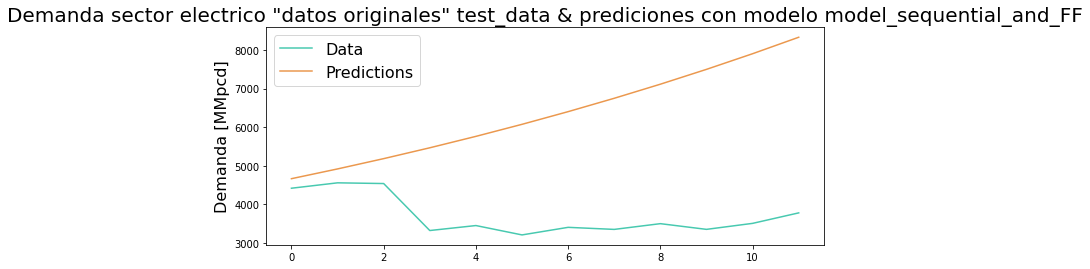

In [53]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, color='#48C9B0')
plt.plot(test_predictions_model_sequential_and_FF_2d, color='#EB984E')
plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Demanda sector electrico "datos originales" test_data & prediciones con modelo model_sequential_and_FF', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [54]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_sequential_and_FF = mean_absolute_percentage_error(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_sequential_and_FF_2d)
RMSE_predictions_model_sequential_and_FF = np.sqrt(mean_squared_error(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_sequential_and_FF_2d))

print('MAPE:', MAPE_predictions_model_sequential_and_FF)
print('RMSE:', RMSE_predictions_model_sequential_and_FF)

MAPE: 0.7595487998491411
RMSE: 3023.409623489953
